# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import os
from imageio import imread
from PIL import Image, ImageFilter, ImageEnhance
import pathlib
import cv2
from skimage.transform import resize
from skimage import io
import datetime
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os

# Path to 'My Drive'
drive_path = '/content/drive/MyDrive/Colab_Notebooks/Gesture_Recognition/'

# List all files and folders in My Drive
files = os.listdir(drive_path)

# Print the file names
for file in files:
    print(file)

Neural_Nets_Project_Starter_Code.ipynb
Project_data.zip


In [ ]:
# !unzip /content/drive/MyDrive/Colab_Notebooks/Gesture_Recognition/Project_data.zip

Archive:  /content/drive/MyDrive/Colab_Notebooks/Gesture_Recognition/Project_data.zip
replace Project_data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
batch_size = 32
seq_idx = range(0,30)
print(len(seq_idx))

enable_augmentation = False # augmentation of Data

# image dimensions
dim_x, dim_y = 120, 120

30


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size, is_train = False, augmention = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx#create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                # print( 'img url = ', (source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]))
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmention and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    center_crop_size = 120
                    start_row = (image.shape[0] - 120) // 2
                    start_col = (image.shape[1] - 120) // 2
                    cropped_image = image[start_row:start_row + center_crop_size, start_col:start_col + center_crop_size, :]

                    # Resize to target dimensions
                    resized_image = cv2.resize(cropped_image, (y, z))  # y, z are target dimensions

                    # Normalize
#                     normalized_image = resized_image / 255.0
                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_image = np.array(Image.fromarray(resized_image, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_image = np.array(Image.fromarray(resized_image, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_image = np.array(Image.fromarray(resized_image, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_image = np.array(Image.fromarray(resized_image, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_image = np.array(ImageEnhance.Brightness((Image.fromarray(resized_image, 'RGB'))).enhance(1.5))
                  

                    batch_data[folder,idx,:,:,0] = resized_image[:, :, 0]
                    batch_data[folder,idx,:,:,1] = resized_image[:, :, 1]
                    batch_data[folder,idx,:,:,2] = resized_image[:, :, 2]

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches

        if (len(t)%batch_size) != 0:
            batch_size = len(t)%batch_size
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video,
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            # randomly enabling augmentation and augmentation type
            aug_type = None
            if is_train and augmention and rn.randint(0,1) == 1:
                aug_type = rn.randint(0, 4) #randomly selecting augmentation type

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    center_crop_size = 120
                    start_row = (image.shape[0] - 120) // 2
                    start_col = (image.shape[1] - 120) // 2
                    cropped_image = image[start_row:start_row + center_crop_size, start_col:start_col + center_crop_size, :]
                    resized_image = cv2.resize(cropped_image, (y, z))  # y, z are target dimensions
#                     normalized_image = resized_image / 255.0
                    
                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_image = np.array(Image.fromarray(resized_image, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_image = np.array(Image.fromarray(resized_image, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_image = np.array(Image.fromarray(resized_image, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_image = np.array(Image.fromarray(resized_image, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_image = np.array(ImageEnhance.Brightness((Image.fromarray(resized_image, 'RGB'))).enhance(1.5))
                  
                    batch_data[folder,idx,:,:,0] = resized_image[:, :, 0]
                    batch_data[folder,idx,:,:,1] = resized_image[:, :, 1]
                    batch_data[folder,idx,:,:,2] = resized_image[:, :, 2]

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels




Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier

print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [6]:
# testing generative
test_gen = generator(train_path, train_doc, batch_size)
d = next(test_gen)[0]

Source path =  /datasets/Project_data/train ; batch size = 32


### Show Randomly select 30 images

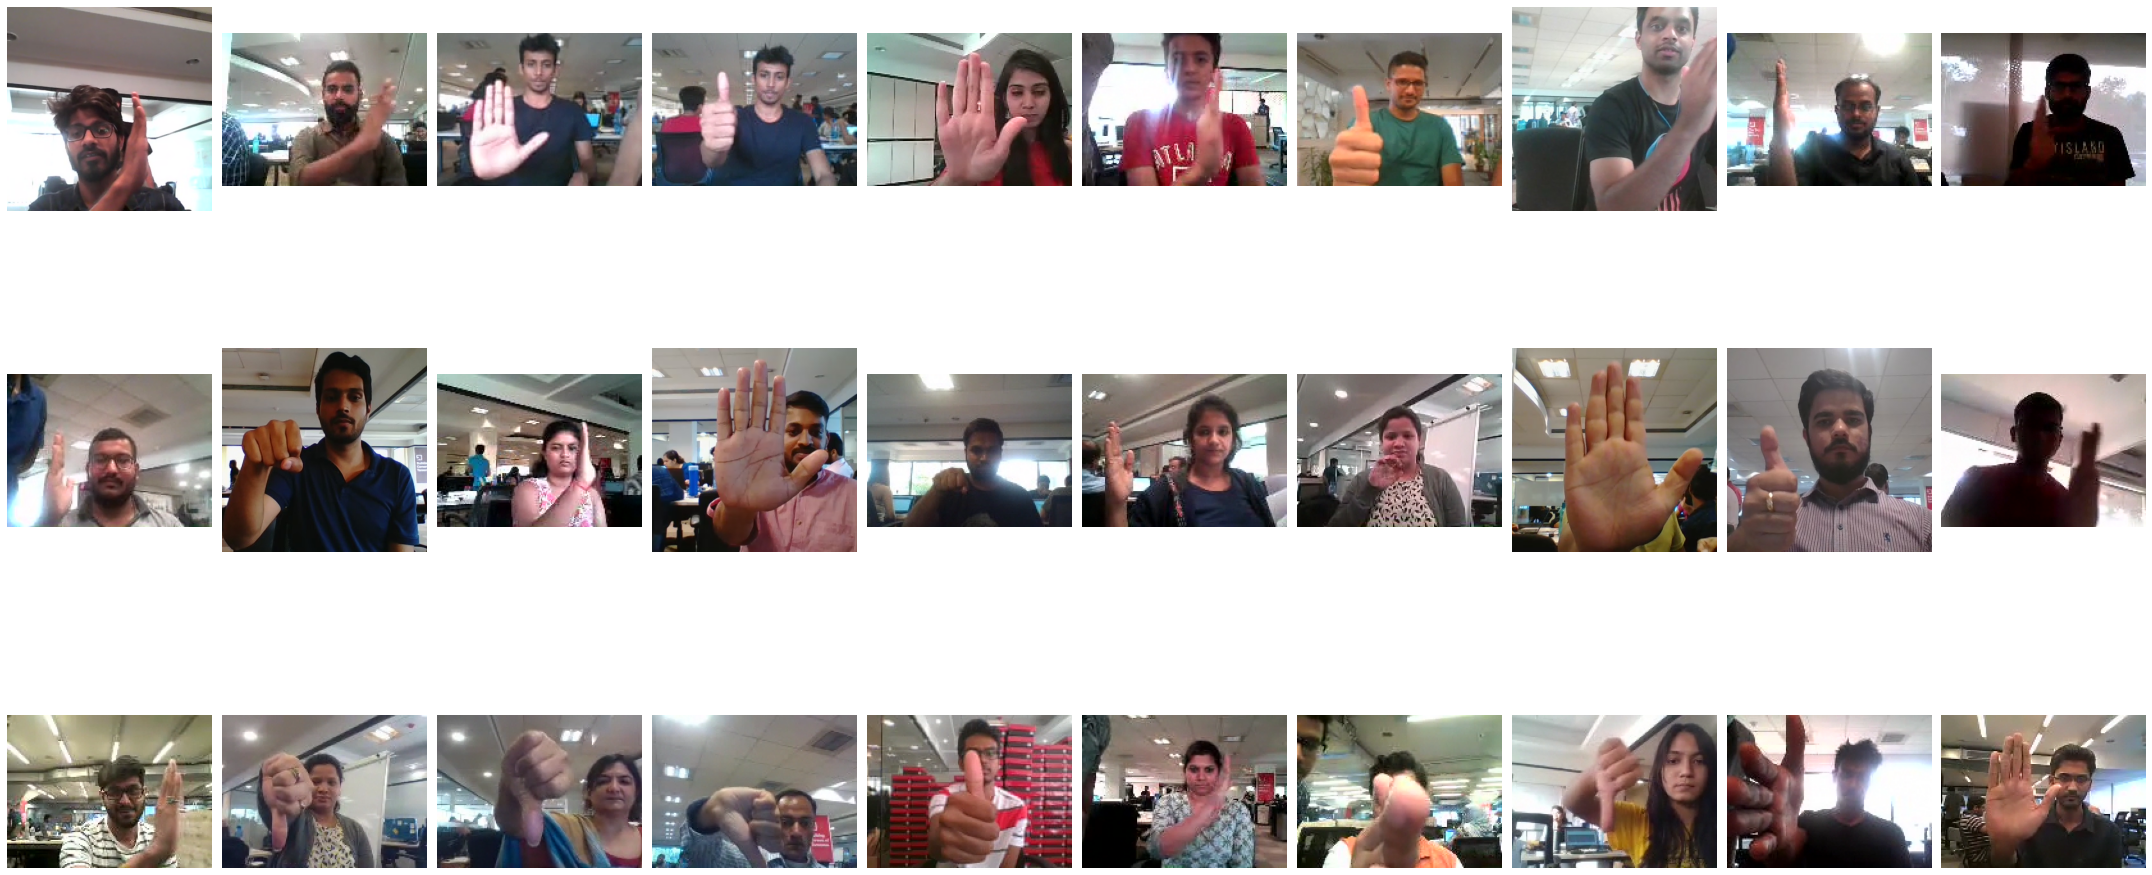

In [54]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(train_path)

# Get all image paths
image_paths = list(data_dir_train.glob('*/*.png'))

# Randomly select 30 images
selected_images = rn.sample(image_paths, min(len(image_paths), 30))

# Display the images
plt.figure(figsize=(30, 20))
columns = 10
for i, img_path in enumerate(selected_images):
    image = mpimg.imread(img_path)
    plt.subplot(len(selected_images) // columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis('off')  # Hide axes for better visualization

plt.tight_layout()
plt.show()


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Dropout, TimeDistributed, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#write your model here
input_shape = (len(seq_idx), dim_x, dim_y, 3)
print(input_shape)
np.random.seed(30)

(30, 120, 120, 3)


## Model 1 (Base Model: 2 Conv3D)

In [8]:
model_1 = Sequential()
model_1.add(Conv3D(32, kernel_size=(3,3,3), padding="Same", activation='relu', input_shape=input_shape))
model_1.add(MaxPooling3D(pool_size=(2,2,2)))
model_1.add(BatchNormalization())

model_1.add(Conv3D(64, kernel_size=(3,3,3), padding="Same", activation='relu'))
model_1.add(MaxPooling3D(pool_size=(2,2,2)))
model_1.add(BatchNormalization())

model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(5, activation='softmax'))

2024-12-03 12:45:56.177205: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-12-03 12:45:56.177269: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
optimiser = Adam(learning_rate=0.001)#write your optimizer
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 60, 60, 32)   128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 30, 30, 64)    0         
 3D)                                                             
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
batch_size = 32
print("enable_augmentation: ",enable_augmentation)
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

enable_augmentation:  False


In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)# write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
history_1 = model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32
Epoch 1/50


2024-12-03 12:46:11.356807: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 73.2334 - categorical_accuracy: 0.4042Source path =  /datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 2334.42969, saving model to model_init_2024-12-0312_45_46.315884/model-00001-73.23335-0.40422-2334.42969-0.24000.keras
21/21 [==============================] - 52s 2s/step - loss: 73.2334 - categorical_accuracy: 0.4042 - val_loss: 2334.4297 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 8.9788 - categorical_accuracy: 0.6501
Epoch 00002: val_loss improved from 2334.42969 to 619.05701, saving model to model_init_2024-12-0312_45_46.315884/model-00002-8.97884-0.65010-619.05701-0.18750.keras
21/21 [==============================] - 31s 1s/step - loss: 8.9788 - categorical_accuracy: 0.6501 - val_loss: 619.0570 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 2.17

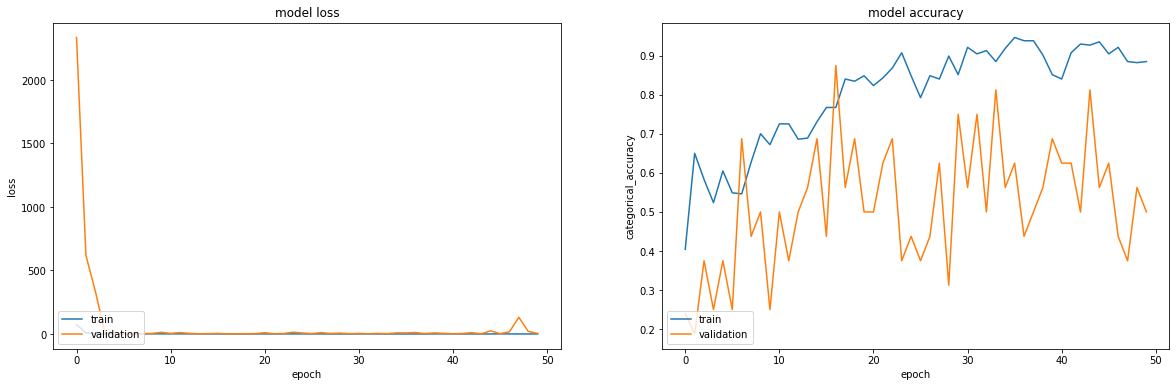

In [14]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history_1.history['loss'])
ax1 = plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history_1.history['categorical_accuracy'])
ax2 = plt.plot(history_1.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

## Model 2 (Using 5 Conv3D)

In [15]:
model_2 = Sequential()
model_2.add(Conv3D(32, kernel_size=(3,3,3), padding="Same", activation='relu', input_shape=input_shape))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))
model_2.add(BatchNormalization())

model_2.add(Conv3D(64, kernel_size=(3,3,3), padding="Same", activation='relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))
model_2.add(BatchNormalization())

model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [16]:
optimiser = Adam(learning_rate=0.001)#write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 30, 120, 120, 32)  2624      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 15, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 15, 60, 60, 32)   128       
 hNormalization)                                                 
                                                                 
 conv3d_3 (Conv3D)           (None, 15, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 30, 30, 64)    0         
 3D)                                                             
                                                      

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [17]:
history_2 = model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 74.1676 - categorical_accuracy: 0.4034
Epoch 00001: val_loss did not improve from 1.00390
21/21 [==============================] - 22s 1s/step - loss: 74.1676 - categorical_accuracy: 0.4034 - val_loss: 2532.8384 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 23.4555 - categorical_accuracy: 0.4566
Epoch 00002: val_loss did not improve from 1.00390
21/21 [==============================] - 23s 1s/step - loss: 23.4555 - categorical_accuracy: 0.4566 - val_loss: 951.0731 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 3.9684 - categorical_accuracy: 0.3277
Epoch 00003: val_loss did not improve from 1.00390
21/21 [==============================] - 22s 1s/step - loss: 3.9684 - categorical_accuracy: 0.3277 - val_loss: 915.0688 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 4/50
21/21 [==

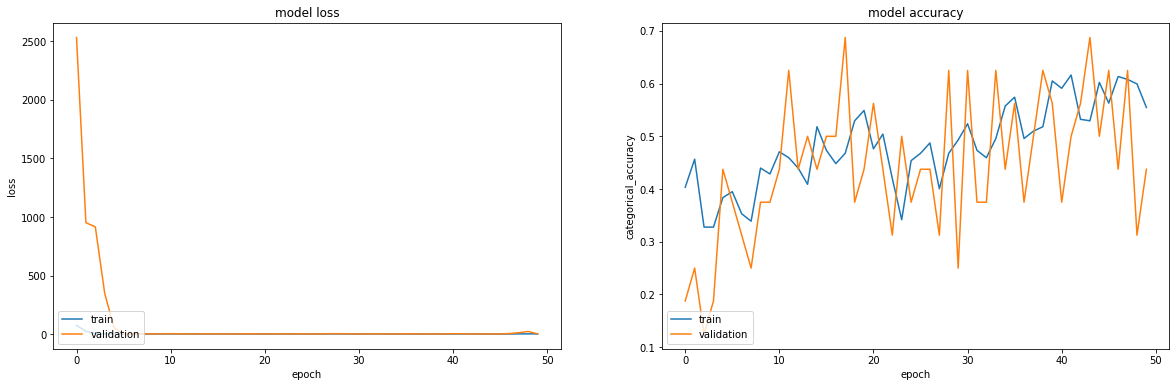

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history_2.history['loss'])
ax1 = plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history_2.history['categorical_accuracy'])
ax2 = plt.plot(history_2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

## Model 3 (Using BatchNormalization with Conv3D and Dropout in Dense layers)

In [24]:
model_3 = Sequential()
model_3.add(Conv3D(32, kernel_size=(3,3,3), padding="Same", activation='relu', input_shape=input_shape))
model_3.add(MaxPooling3D(pool_size=(2,2,2)))
model_3.add(BatchNormalization())

model_3.add(Conv3D(64, kernel_size=(3,3,3), padding="Same", activation='relu'))
model_3.add(MaxPooling3D(pool_size=(2,2,2)))
model_3.add(BatchNormalization())

model_3.add(Conv3D(128, kernel_size=(3,3,3), padding="Same", activation='relu'))
model_3.add(MaxPooling3D(pool_size=(2,2,2)))
model_3.add(BatchNormalization())

model_3.add(Conv3D(512, kernel_size=(3,3,3), padding="Same", activation='relu'))
model_3.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid'))
model_3.add(BatchNormalization())

model_3.add(Flatten())
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [25]:
optimiser = Adam(learning_rate=0.001)#write your optimizer
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_10 (Conv3D)          (None, 30, 120, 120, 32)  2624      
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 15, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 15, 60, 60, 32)   128       
 ormalization)                                                   
                                                                 
 conv3d_11 (Conv3D)          (None, 15, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 7, 30, 30, 64)    0         
 g3D)                                                            
                                                      

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [26]:
history_3 = model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 21.7724 - categorical_accuracy: 0.2829
Epoch 00001: val_loss did not improve from 1.12681
21/21 [==============================] - 23s 1s/step - loss: 21.7724 - categorical_accuracy: 0.2829 - val_loss: 1363.5278 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 16.1081 - categorical_accuracy: 0.2493
Epoch 00002: val_loss did not improve from 1.12681
21/21 [==============================] - 22s 1s/step - loss: 16.1081 - categorical_accuracy: 0.2493 - val_loss: 573.2026 - val_categorical_accuracy: 0.0625 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 6.3907 - categorical_accuracy: 0.2773
Epoch 00003: val_loss did not improve from 1.12681
21/21 [==============================] - 20s 1s/step - loss: 6.3907 - categorical_accuracy: 0.2773 - val_loss: 127.9684 - val_categorical_accuracy: 0.4375 - lr: 0.0010
Epoch 4/30
21/21 [==

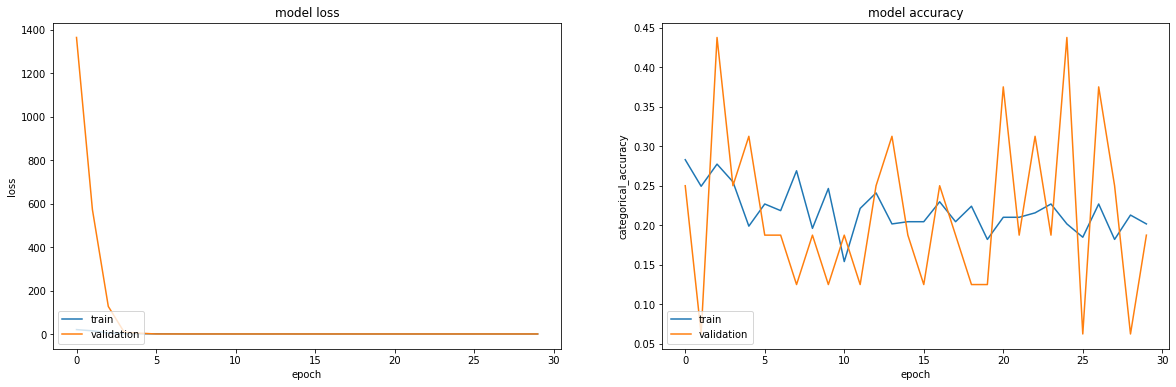

In [27]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history_3.history['loss'])
ax1 = plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history_3.history['categorical_accuracy'])
ax2 = plt.plot(history_3.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

## Model 4 (Increased Conv3D layers and Dense Layers with Dropout and BatchNormalization)

In [28]:
model_4 = Sequential()
model_4.add(Conv3D(32, kernel_size=(3,3,3), padding="Same", activation='relu', input_shape=input_shape))
model_4.add(MaxPooling3D(pool_size=(2,2,2)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Conv3D(64, kernel_size=(3,3,3), padding="Same", activation='relu'))
model_4.add(MaxPooling3D(pool_size=(2,2,2)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Conv3D(128, kernel_size=(3,3,3), padding="Same", activation='relu'))
model_4.add(MaxPooling3D(pool_size=(2,2,2)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Conv3D(256, kernel_size=(3,3,3), padding="Same", activation='relu'))
model_4.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding="same"))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Conv3D(512, kernel_size=(3,3,3), padding="Same", activation='relu'))
model_4.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.3))

model_4.add(Flatten())
model_4.add(Dense(512, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [29]:
optimiser = Adam(learning_rate=0.001)#write your optimizer
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 30, 120, 120, 32)  2624      
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 15, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 batch_normalization_4 (Batc  (None, 15, 60, 60, 32)   128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 15, 60, 60, 32)    0         
                                                                 
 conv3d_15 (Conv3D)          (None, 15, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 7, 30, 30, 64)   

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [30]:
history_4 = model_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 7.6357 - categorical_accuracy: 0.2521
Epoch 00001: val_loss did not improve from 1.12681
21/21 [==============================] - 22s 1s/step - loss: 7.6357 - categorical_accuracy: 0.2521 - val_loss: 245.5562 - val_categorical_accuracy: 0.0625 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 7.9765 - categorical_accuracy: 0.2241
Epoch 00002: val_loss did not improve from 1.12681
21/21 [==============================] - 21s 1s/step - loss: 7.9765 - categorical_accuracy: 0.2241 - val_loss: 181.3746 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 5.7831 - categorical_accuracy: 0.2017
Epoch 00003: val_loss did not improve from 1.12681
21/21 [==============================] - 22s 1s/step - loss: 5.7831 - categorical_accuracy: 0.2017 - val_loss: 26.5137 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 4/30
21/21 [========

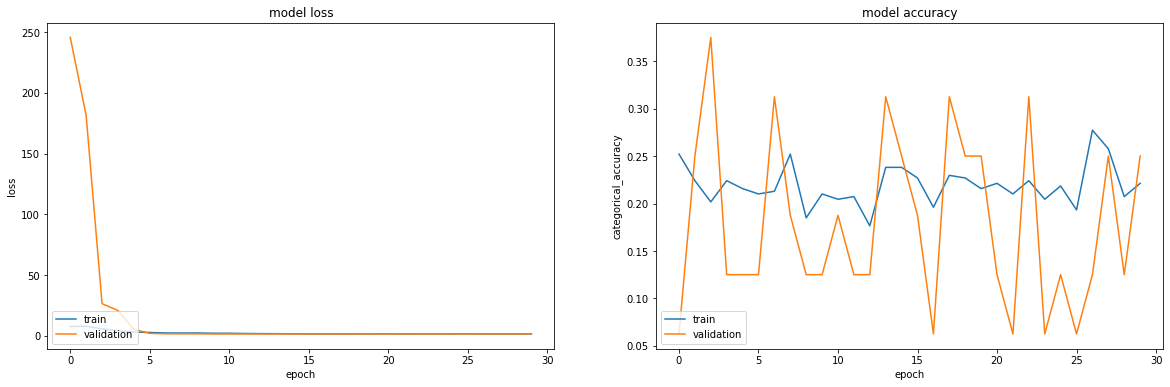

In [31]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history_4.history['loss'])
ax1 = plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history_4.history['categorical_accuracy'])
ax2 = plt.plot(history_4.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

In [11]:
from tensorflow.keras.layers import LSTM, GRU, Reshape

## Model 5

In [9]:
model_5 = Sequential()
model_5.add(Conv3D(32, kernel_size=(3,3,3), padding="Same", activation='relu', input_shape=input_shape))
model_5.add(MaxPooling3D(pool_size=(2,2,2)))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.3))

model_5.add(Conv3D(64, kernel_size=(3,3,3), padding="Same", activation='relu'))
model_5.add(MaxPooling3D(pool_size=(2,2,2)))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.3))

model_5.add(Conv3D(128, kernel_size=(3,3,3), padding="Same", activation='relu'))
model_5.add(MaxPooling3D(pool_size=(2,2,2)))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.3))

model_5.add(Conv3D(256, kernel_size=(3,3,3), padding="Same", activation='relu'))
model_5.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding="same"))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.3))

model_5.add(Conv3D(512, kernel_size=(3,3,3), padding="Same", activation='relu'))
model_5.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.3))

model_5.add(Reshape((-1, 256)))  # Adjust based on dimensions after Conv3D

# LSTM and Dense Layers
model_5.add(LSTM(128))
model_5.add(Dropout(0.5))
model_5.add(Dense(128, activation='relu'))
model_5.add(Dense(5, activation='softmax'))

2024-12-03 08:59:56.003395: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-12-03 08:59:56.003460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
optimiser = Adam(learning_rate=0.001)#write your optimizer
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 60, 60, 32)   128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 15, 60, 60, 32)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 30, 30, 64)    0

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
history_5 = model_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32
Epoch 1/30


2024-12-03 09:00:51.412800: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


42/42 [==============================] - ETA: 0s - loss: 1.6357 - categorical_accuracy: 0.2330Source path =  /datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.64035, saving model to model_init_2024-12-0308_59_18.980078/model-00001-1.63573-0.23303-1.64035-0.19000.keras
42/42 [==============================] - 98s 2s/step - loss: 1.6357 - categorical_accuracy: 0.2330 - val_loss: 1.6404 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.6201 - categorical_accuracy: 0.2500
Epoch 00002: val_loss improved from 1.64035 to 1.63141, saving model to model_init_2024-12-0308_59_18.980078/model-00002-1.62008-0.25000-1.63141-0.18750.keras
42/42 [==============================] - 39s 903ms/step - loss: 1.6201 - categorical_accuracy: 0.2500 - val_loss: 1.6314 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.6213 - categorical_a

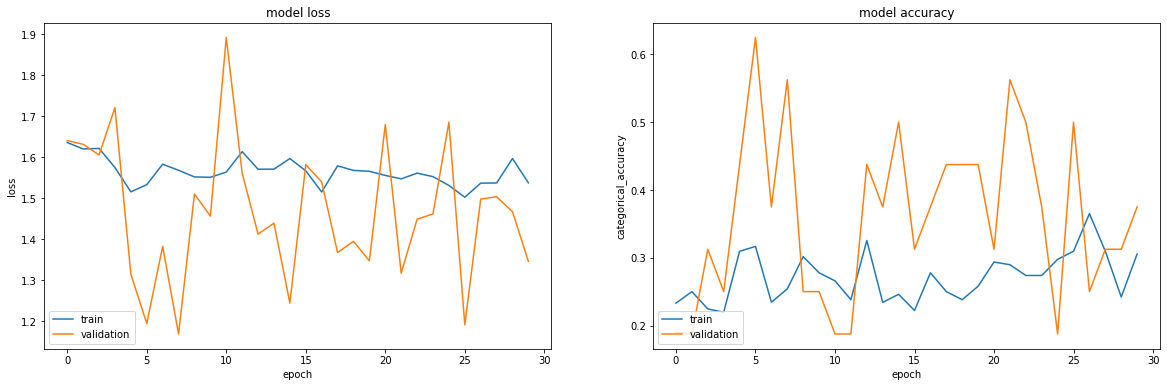

In [16]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history_5.history['loss'])
ax1 = plt.plot(history_5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history_5.history['categorical_accuracy'])
ax2 = plt.plot(history_5.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Model 6

The TimeDistributed layer in Keras (or TensorFlow) is used to apply a layer to every temporal slice of an input independently. It's particularly useful when building models for sequence data where each timestep involves the same operation, such as applying a convolutional neural network (CNN) on each frame of a video sequence.

In [ ]:
model_6 = Sequential()

model_6.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(input_shape)))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))
model_6.add(TimeDistributed(Dropout(0.25)))

model_6.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))
model_6.add(TimeDistributed(Dropout(0.25)))

model_6.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))
model_6.add(TimeDistributed(Dropout(0.25)))

model_6.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))
model_6.add(TimeDistributed(Dropout(0.25)))

model_6.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))
model_6.add(TimeDistributed(Dropout(0.25)))

model_6.add(TimeDistributed(Flatten()))


model_6.add(LSTM(64))
model_6.add(Dropout(0.25))
model_6.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = Adam(learning_rate=0.001)#write your optimizer
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_6.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)  

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
num_epochs = 30
history_6 = model_6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 1.6393 - categorical_accuracy: 0.2360Source path =  /datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss did not improve from 1.16843
42/42 [==============================] - 93s 2s/step - loss: 1.6393 - categorical_accuracy: 0.2360 - val_loss: 1.6754 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 1.6548 - categorical_accuracy: 0.2160
Epoch 00002: val_loss did not improve from 1.16843
42/42 [==============================] - 39s 946ms/step - loss: 1.6548 - categorical_accuracy: 0.2160 - val_loss: 1.5425 - val_categorical_accuracy: 0.3125 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 1.6270 - categorical_accuracy: 0.2568
Epoch 00003: val_loss did not improve from 1.16843
42/42 [==============================] - 39s 947ms/step - loss: 1.6270 -

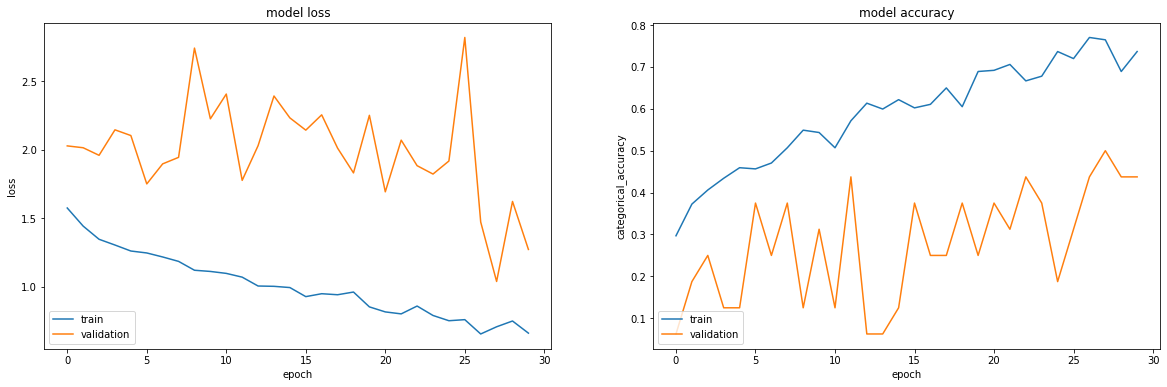

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history_6.history['loss'])
ax1 = plt.plot(history_6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history_6.history['categorical_accuracy'])
ax2 = plt.plot(history_6.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Model 7

In [ ]:
model_7 = Sequential()

model_7.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(input_shape)))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))
model_7.add(TimeDistributed(Dropout(0.25)))

model_7.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))
model_7.add(TimeDistributed(Dropout(0.25)))

model_7.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))
model_7.add(TimeDistributed(Dropout(0.25)))

model_7.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))
model_7.add(TimeDistributed(Dropout(0.25)))

model_7.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(MaxPooling2D((2, 2))))
model_7.add(TimeDistributed(Dropout(0.25)))

model_7.add(TimeDistributed(Flatten()))


model_7.add(LSTM(64))
model_7.add(Dropout(0.25))

model_7.add(Dense(128,activation='relu'))
model_7.add(Dropout(0.25))

model_7.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = Adam(learning_rate=0.001)#write your optimizer
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_42 (TimeDi  (None, 30, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 30, 64, 64, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, 30, 32, 32, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 30, 32, 32, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 30, 32, 32, 32)  

In [ ]:
num_epochs = 40
history_7 = model_7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32
Epoch 1/40
42/42 [==============================] - ETA: 0s - loss: 1.6353 - categorical_accuracy: 0.2353Source path =  /datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.61069, saving model to model_init_2024-12-0309_59_20.407207/model-00001-1.63529-0.23529-1.61069-0.27000.keras
42/42 [==============================] - 80s 2s/step - loss: 1.6353 - categorical_accuracy: 0.2353 - val_loss: 1.6107 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/40
42/42 [==============================] - ETA: 0s - loss: 1.6195 - categorical_accuracy: 0.2160
Epoch 00002: val_loss improved from 1.61069 to 1.58870, saving model to model_init_2024-12-0309_59_20.407207/model-00002-1.61950-0.21599-1.58870-0.25000.keras
42/42 [==============================] - 32s 787ms/step - loss: 1.6195 - categorical_accuracy: 0.2160 - val_loss: 1.5887 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/40
42/42 

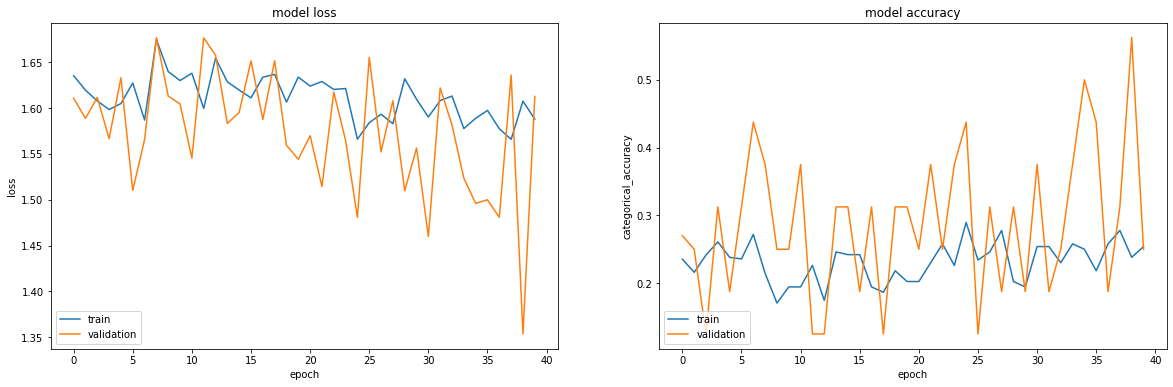

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history_7.history['loss'])
ax1 = plt.plot(history_7.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history_7.history['categorical_accuracy'])
ax2 = plt.plot(history_7.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Model 8

In [ ]:
model_8 = Sequential()

model_8.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(input_shape)))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
model_8.add(TimeDistributed(Dropout(0.25)))

model_8.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
model_8.add(TimeDistributed(Dropout(0.25)))

model_8.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
model_8.add(TimeDistributed(Dropout(0.25)))

model_8.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
model_8.add(TimeDistributed(Dropout(0.25)))

model_8.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_8.add(TimeDistributed(BatchNormalization()))
model_8.add(TimeDistributed(MaxPooling2D((2, 2))))
model_8.add(TimeDistributed(Dropout(0.25)))

model_8.add(TimeDistributed(Flatten()))


model_8.add(GRU(128))
model_8.add(Dropout(0.25))

model_8.add(Dense(128,activation='relu'))
model_8.add(Dropout(0.25))

model_8.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = Adam(learning_rate=0.001)#write your optimizer
model_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_8.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_63 (TimeDi  (None, 30, 64, 64, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_64 (TimeDi  (None, 30, 64, 64, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 30, 32, 32, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 30, 32, 32, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 30, 32, 32, 32)  

In [ ]:
history_8 = model_8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/40
42/42 [==============================] - ETA: 0s - loss: 1.9249 - categorical_accuracy: 0.2262
Epoch 00001: val_loss did not improve from 1.35356
42/42 [==============================] - 18s 383ms/step - loss: 1.9249 - categorical_accuracy: 0.2262 - val_loss: 1.7196 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 2/40
42/42 [==============================] - ETA: 0s - loss: 1.7603 - categorical_accuracy: 0.2381
Epoch 00002: val_loss did not improve from 1.35356
42/42 [==============================] - 15s 357ms/step - loss: 1.7603 - categorical_accuracy: 0.2381 - val_loss: 1.7175 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/40
42/42 [==============================] - ETA: 0s - loss: 1.7755 - categorical_accuracy: 0.2262
Epoch 00003: val_loss did not improve from 1.35356
42/42 [==============================] - 15s 360ms/step - loss: 1.7755 - categorical_accuracy: 0.2262 - val_loss: 1.6107 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 4/40
42/42 [====

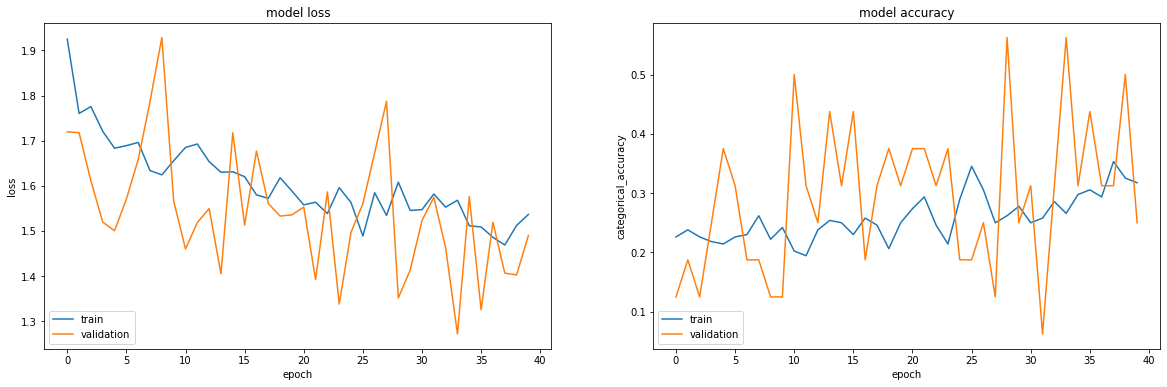

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history_8.history['loss'])
ax1 = plt.plot(history_8.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history_8.history['categorical_accuracy'])
ax2 = plt.plot(history_8.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Model 9

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

input_shape = (30,120,120,3)
        
model_9 = Sequential()
model_9.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


model_9.add(TimeDistributed(BatchNormalization()))
model_9.add(TimeDistributed(MaxPooling2D((2, 2))))
model_9.add(TimeDistributed(Flatten()))
model_9.add(Dropout(0.25))

model_9.add(GRU(128))
model_9.add(Dropout(0.25))

model_9.add(Dense(128,activation='relu'))
model_9.add(Dropout(0.25))

model_9.add(Dense(5, activation='softmax'))

17235968/17225924 [==============================] - 2s 0us/step


In [ ]:
optimiser = Adam(learning_rate=0.001)#write your optimizer
model_9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_9.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 30, 1024)         

In [ ]:
num_epochs = 20
history_9 = model_9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 0.0615 - categorical_accuracy: 0.9804
Epoch 00001: val_loss did not improve from 0.14081
21/21 [==============================] - 42s 2s/step - loss: 0.0615 - categorical_accuracy: 0.9804 - val_loss: 0.3649 - val_categorical_accuracy: 0.8125 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.0194 - categorical_accuracy: 0.9972
Epoch 00002: val_loss did not improve from 0.14081
21/21 [==============================] - 24s 1s/step - loss: 0.0194 - categorical_accuracy: 0.9972 - val_loss: 0.1503 - val_categorical_accuracy: 0.9375 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.0159 - categorical_accuracy: 0.9944
Epoch 00003: val_loss improved from 0.14081 to 0.07759, saving model to model_init_2024-12-0312_45_46.315884/model-00003-0.01587-0.99440-0.07759-1.00000.keras
21/21 [==============================] - 22s 1s/step - loss: 0.0159 - categorical_accurac

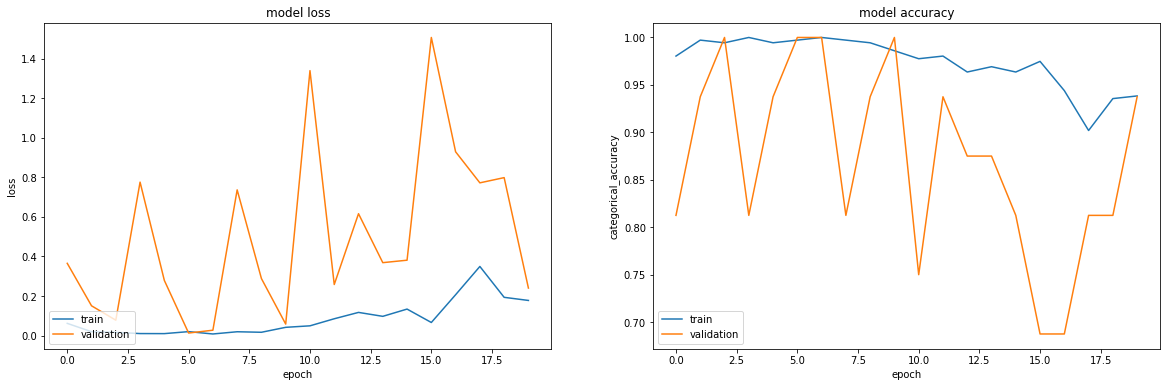

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history_9.history['loss'])
ax1 = plt.plot(history_9.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history_9.history['categorical_accuracy'])
ax2 = plt.plot(history_9.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')